**UDALOV EGOR**

The goal is to train evolutoinary algorithm to solve classic optimization function. The function is **Rastrigin** function, but it is reversed and shifted.
The maximum value that you can achieve is 10 and this is your goal!

Send me a link to your colab notebook to
***michael.melnik@itmo.ru***

In [1]:
import numpy
import deap
import math
import numpy as np
from deap import tools, base, creator, algorithms
import numpy.random as rnd

In [2]:
#Shifted Rastrigin function

noise = rnd.random(1000)

def rastrigin(individual):
    individual = individual + noise[0:len(individual)]
    n = len(individual)

    pi = math.pi
    dn = 1.0 / n
    a = 10.0
    b = 0.2
    c = 2 * pi
    s1 = 0.0
    s2 = 0.0
    for i in range(n):
        s1 += individual[i] * individual[i]
        s2 += np.cos(c*individual[i])
    s1 = -a * math.exp(-b*math.sqrt(dn*s1))
    s2 = -math.exp(dn*s2)
    result = s1+s2 + a + math.exp(1)
    result = -result
    result = result + a
    result = math.fabs(result)
    return result

In [4]:
solution = [0 for _ in range(20)]
rastrigin(solution)

7.141491825749732

In [5]:
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

In [6]:
def mutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.2)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual,

In [61]:
class SimpleGAExperiment:
    
    def factory(self):
        return rnd.random(self.dimension) * 10 - 5 # random range from -5 to 5

    def __init__(self, 
                 function, 
                 dimension, 
                 pop_size, 
                 iterations, 
                 probs,
                 mutate,
                 mutate_kwargs,
                 select,
                 select_kwargs,
                 crossover,
                 crossover_kwargs,
                 lambda_ratio):
        
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = probs['mut'] # 0.6
        self.cross_prob = probs['cross'] # 0.3
        self.lambda_ratio = lambda_ratio # 0.8

        self.function = function
        self.dimension = dimension

        # self.pool = Pool(5)
        self.engine = base.Toolbox()
        # self.engine.register("map", self.pool.map)
        self.engine.register("map", map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list, self.engine.individual, self.pop_size)
        
        # self.engine.register("mate", tools.cxOnePoint)
        # self.engine.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
        # self.engine.register("select", tools.selTournament, tournsize=4)
        
        self.engine.register("mate", crossover, **crossover_kwargs)
        self.engine.register("mutate", mutate, **mutate_kwargs)
        self.engine.register("select", select, **select_kwargs)
        
        self.engine.register("evaluate", self.function)


    def run(self, verbose=True):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaMuPlusLambda(pop, 
                                             self.engine, 
                                             mu=self.pop_size, 
                                             lambda_=int(self.pop_size*self.lambda_ratio), 
                                             cxpb=self.cross_prob, 
                                             mutpb=self.mut_prob,
                                             ngen=self.iterations,
                                             stats=stats, 
                                             halloffame=hof, 
                                             verbose=verbose)
        best_fit = hof[0].fitness.values[0]
        if verbose: print("Best = {}".format(hof[0]))
        if verbose: print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log, best_fit

In [11]:
def function(x):
    res = rastrigin(x)
    return res,

# dimension = 100 # set it to 100
# pop_size = 100 # lets say max is 100
# iterations = 500 # lets say max is 5000
# scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)

def draw_log(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg")
    plt.plot(gen_list, min_list, label="min")
    plt.plot(gen_list, max_list, label="max")
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_logs(log1, log2, lab1, lab2):
    gen1, avg1, std1, max1, min1 = read_log(log1)
    gen2, avg2, std2, max2, min2 = read_log(log2)
    plt.plot(gen1, avg1, label=lab1, color="blue")
    plt.plot(gen1, max1, label="{}_max".format(lab1), color="blue", linewidth=2)
    plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
    plt.plot(gen2, avg2, label=lab2, color="orange")
    plt.plot(gen2, max2, label="{}_max".format(lab2), color="orange", linewidth=2)
    plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [105]:
import itertools
import pandas as pd
from tqdm.auto import tqdm

def grid_search(params_grid: dict, default_params: dict):
    
    params_sets = [dict(zip(params_grid.keys(), v)) for v in itertools.product(*params_grid.values())]
    results = []

    for params_set in tqdm(params_sets, total=len(params_sets)):

        params_set_ = {}
        
        for (k, v) in params_set.items():
            if any([kw in k for kw in ['mutate_kwargs', 'select_kwargs', 'crossover_kwargs']]):
                for kw in ['mutate_kwargs', 'select_kwargs', 'crossover_kwargs']:
                    if kw in k:
                        if kw not in params_set_.keys():
                            params_set_[kw] = {}
                        params_set_[kw][k.split('/')[-1]] = v
            else:
                params_set_[k] = v
                
        
        scenario = SimpleGAExperiment(**default_params, **params_set_)

        last_log, best_fit = scenario.run(verbose=False)

        results.append(list(params_set.values())+[best_fit])

    results = pd.DataFrame(results, columns=list(params_grid.keys())+['best_fit'])

    return results

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

def simple_plot(x, y, xlabel=None, ylabel=None, scatterplot=False, lineplot=True,
                params_dict={'figure.figsize': (20,8), 'font.size': 20, 'lines.linewidth': 5, 'lines.markersize': 15},
                xticks=None, yticks=None):
    if params_dict is not None:
        plt.rcParams.update(params_dict)
    plt.figure()
    sns.set_style("darkgrid")
    if lineplot: sns.lineplot(x=x, y=y)
    if scatterplot: sns.scatterplot(x=x, y=y)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None: plt.ylabel(ylabel)
    if xticks != None: plt.xticks(xticks)
    if yticks != None: plt.yticks(yticks)    
    plt.show()  

# Varying only mutate_kwargs/sigma

In [ ]:
default_params = {'function': function, 'dimension': 100, 'iterations': 5000,
                  'mutate': tools.mutGaussian,
                  'select': tools.selTournament,
                  'crossover': tools.cxOnePoint, 
                  'crossover_kwargs': {}}
params_grid = {'pop_size': [80], 
               'lambda_ratio': [0.8], 
               'probs': [{'mut': 0.6, 'cross': 0.3}],
               'select_kwargs/tournsize': [4],
               'mutate_kwargs/mu': [0],
               'mutate_kwargs/sigma': np.arange(0.2, 3.1, 0.2),
               'mutate_kwargs/indpb': [0.2]}

In [124]:
results = grid_search(params_grid, default_params)

  0%|          | 0/15 [00:00<?, ?it/s]

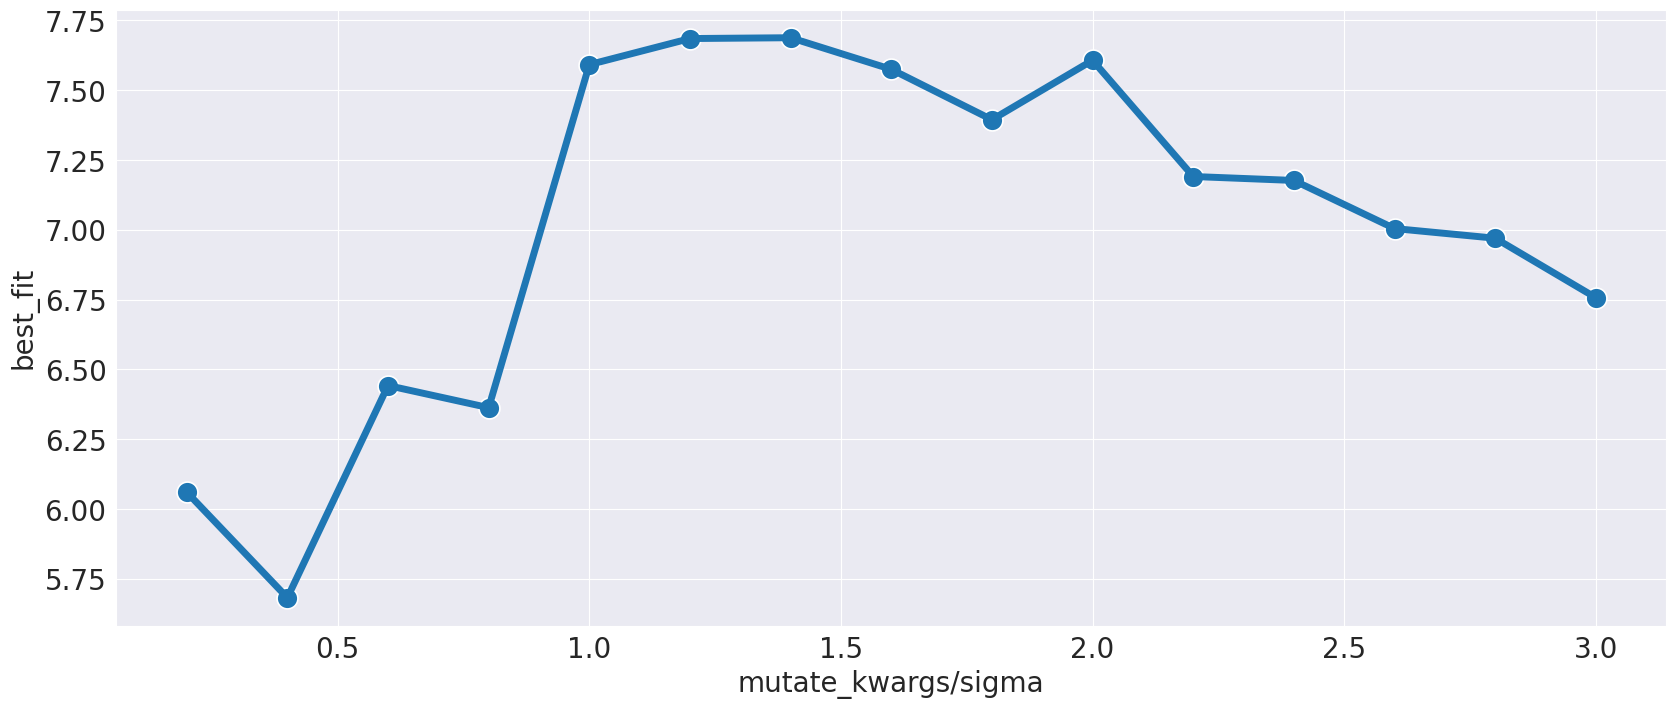

In [125]:
simple_plot(results['mutate_kwargs/sigma'], results['best_fit'], scatterplot=True)

In [126]:
results

,pop_size,lambda_ratio,probs,select_kwargs/tournsize,mutate_kwargs/mu,mutate_kwargs/sigma,mutate_kwargs/indpb,best_fit
0,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,0.2,0.2,6.060590
1,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,0.4,0.2,5.682295
2,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,0.6,0.2,6.442279
3,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,0.8,0.2,6.363052
4,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.0,0.2,7.591865
5,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.2,0.2,7.685255
6,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.2,7.688214
7,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.6,0.2,7.574957
8,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.8,0.2,7.394539
9,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,2.0,0.2,7.607314


In [129]:
results.sort_values(by='best_fit', ascending=False).head(1)

,pop_size,lambda_ratio,probs,select_kwargs/tournsize,mutate_kwargs/mu,mutate_kwargs/sigma,mutate_kwargs/indpb,best_fit
6,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.2,7.688214


# Varying only mutate_kwargs/indpb

In [132]:
default_params = {'function': function, 'dimension': 100, 'iterations': 5000,
                  'mutate': tools.mutGaussian,
                  'select': tools.selTournament,
                  'crossover': tools.cxOnePoint, 
                  'crossover_kwargs': {}}
params_grid = {'pop_size': [80], 
               'lambda_ratio': [0.8], 
               'probs': [{'mut': 0.6, 'cross': 0.3}],
               'select_kwargs/tournsize': [4],
               'mutate_kwargs/mu': [0],
               'mutate_kwargs/sigma': [1.4],
               'mutate_kwargs/indpb': np.arange(0.05, 0.55, 0.05)}

In [134]:
results = grid_search(params_grid, default_params)

  0%|          | 0/10 [00:00<?, ?it/s]

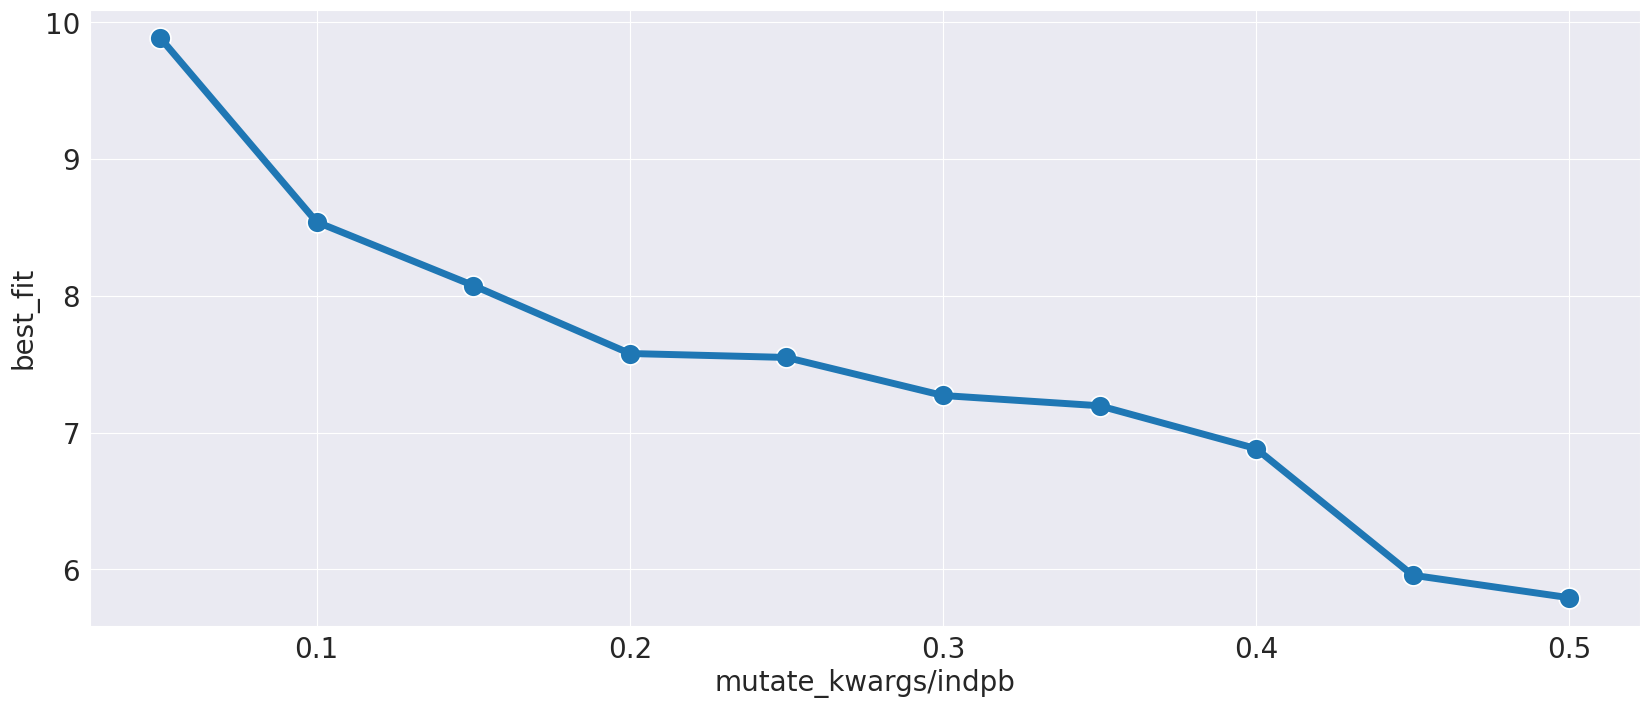

In [135]:
simple_plot(results['mutate_kwargs/indpb'], results['best_fit'], scatterplot=True)

In [136]:
results

,pop_size,lambda_ratio,probs,select_kwargs/tournsize,mutate_kwargs/mu,mutate_kwargs/sigma,mutate_kwargs/indpb,best_fit
0,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.05,9.888462
1,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.10,8.540694
2,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.15,8.075781
3,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.20,7.578309
4,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.25,7.549488
5,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.30,7.271104
6,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.35,7.196062
7,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.40,6.882426
8,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.45,5.956571
9,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.50,5.791688


In [137]:
results.sort_values(by='best_fit', ascending=False).head(1)

,pop_size,lambda_ratio,probs,select_kwargs/tournsize,mutate_kwargs/mu,mutate_kwargs/sigma,mutate_kwargs/indpb,best_fit
0,80,0.8,"{'mut': 0.6, 'cross': 0.3}",4,0,1.4,0.05,9.888462


# Checking the best set of parameters

In [143]:
best_sigma = 1.4
best_indpb = 0.05

params = {'function': function, 
          'dimension': 100, 
          'iterations': 5000,
          'mutate': tools.mutGaussian,
          'select': tools.selTournament,
          'crossover': tools.cxOnePoint, 
          'crossover_kwargs': {},
          'pop_size': 80,
          'lambda_ratio': 0.8,
          'probs': {'mut': 0.6, 'cross': 0.3},
          'select_kwargs': {'tournsize': 4},
          'mutate_kwargs': {'mu': 0, 'sigma': best_sigma, 'indpb': best_indpb}}

In [144]:
scenario = SimpleGAExperiment(**params)

In [146]:
log, best_fit = scenario.run()

gen	nevals	avg    	std     	min    	max    
0  	80    	3.87964	0.167171	3.55474	4.32615
1  	61    	4.03566	0.111549	3.83925	4.3578 
2  	58    	4.16834	0.115618	3.96651	4.3578 
3  	60    	4.30381	0.0650876	4.11944	4.54026
4  	60    	4.38111	0.0746188	4.26284	4.58094
5  	54    	4.45838	0.0842897	4.32615	4.58667
6  	58    	4.54865	0.0445535	4.34682	4.63279
7  	56    	4.58102	0.0289011	4.52674	4.63279
8  	53    	4.61323	0.023901 	4.5683 	4.70721
9  	60    	4.63918	0.0214606	4.58667	4.70721
10 	59    	4.66232	0.0195067	4.63279	4.70721
11 	57    	4.68128	0.00949531	4.65257	4.70721
12 	59    	4.6976 	0.0227138 	4.67736	4.77676
13 	60    	4.72217	0.0344915 	4.68299	4.82003
14 	55    	4.75206	0.0357905 	4.68997	4.82003
15 	59    	4.78574	0.0273543 	4.71957	4.82328
16 	59    	4.81307	0.0165588 	4.77442	4.85651
17 	56    	4.83331	0.0192326 	4.79412	4.8613 
18 	56    	4.85765	0.0164731 	4.81849	4.89932
19 	56    	4.87184	0.0164613 	4.84403	4.93293
20 	57    	4.8879 	0.0162575 	4.84486	4.93293
21 	

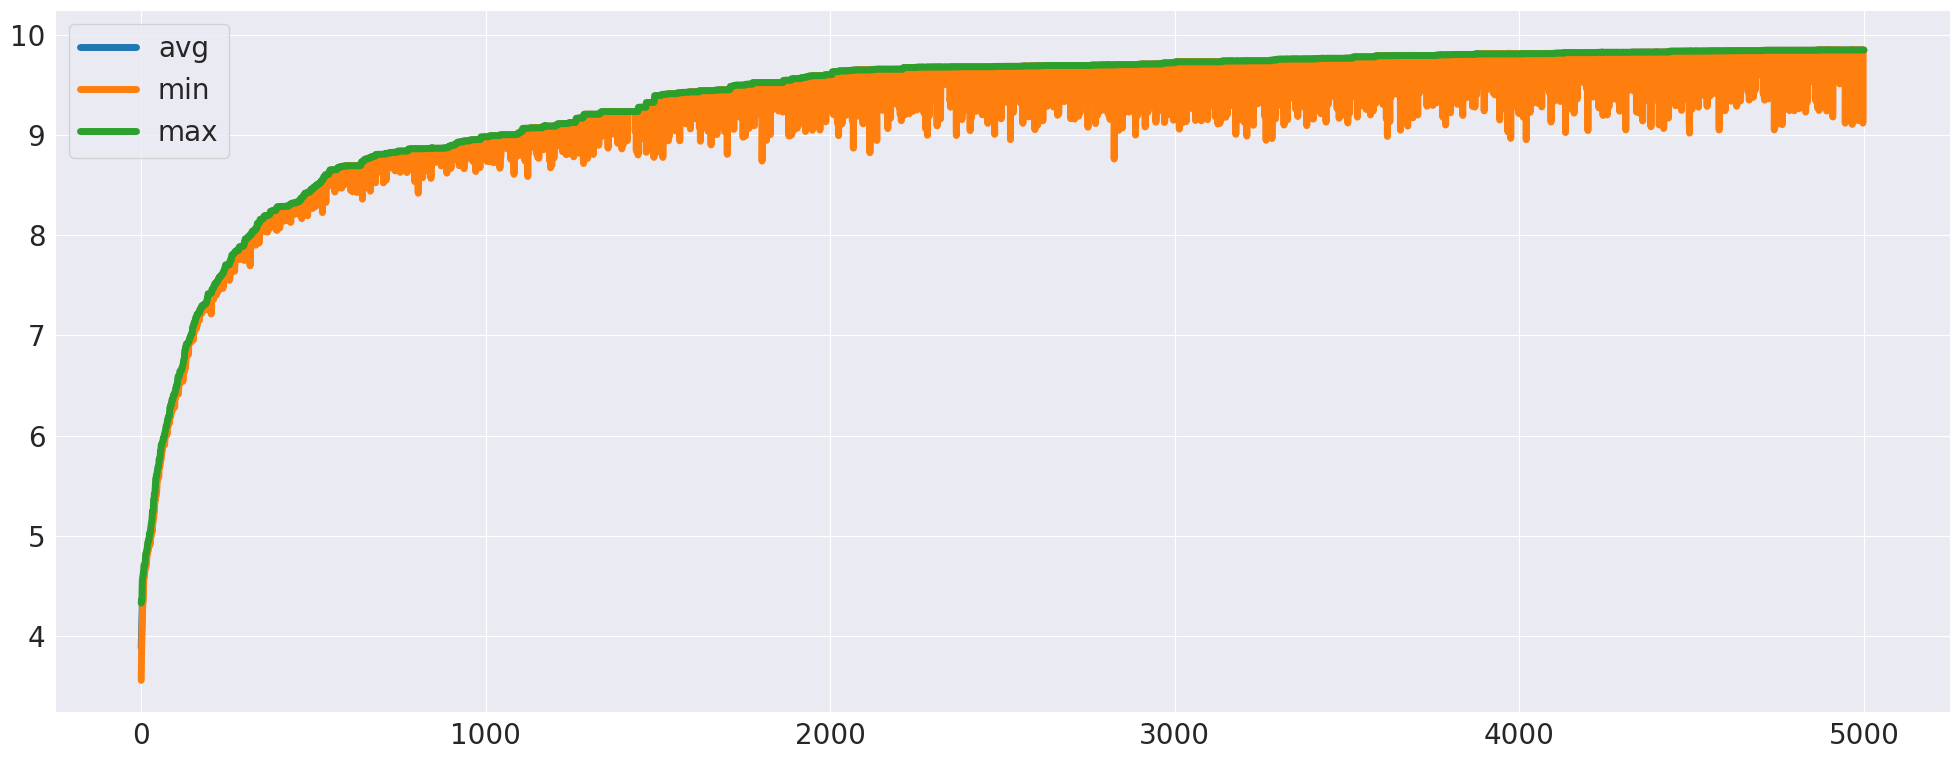

In [147]:
draw_log(log)